In [1]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



from MnistNet import MnistNet

In [2]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# print the seed value
# seed = torch.initial_seed()
# print('Used seed : {}'.format(seed))

In [4]:
mnistnet = MnistNet(num_classes=NUM_CLASSES).to(device)
mnistnet = torch.nn.parallel.DataParallel(mnistnet, device_ids=DEVICE_IDS)
print(mnistnet)
print('MnistNet created')

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [5]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
print(X.shape)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape)

(70000, 784)
(70000, 1, 28, 28)


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                             torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

In [8]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [9]:
def evaluate_model(nn_model):
    nn_model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = nn_model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()

    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current

In [10]:
# create optimizer
# the one that WORKS
optimizer = optim.Adam(params=mnistnet.parameters(), lr=0.0001)
### BELOW is the setting proposed by the original paper - which doesn't train....
# optimizer = optim.SGD(
#     params=alexnet.parameters(),
#     lr=LR_INIT,
#     momentum=MOMENTUM,
#     weight_decay=LR_DECAY)
print('Optimizer created')

Optimizer created


In [11]:
# multiply LR by 1 / 10 after every 30 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

accuracy_test_stat = []
accuracy_train_stat = []
loss_test_stat = []
loss_train_stat = []

# start training!!
print('Starting training...')
total_steps = 1
for epoch in range(NUM_EPOCHS):
    epoch_tr_accuracy = 0
    epoch_tr_loss = 0

    lr_scheduler.step()
    for imgs, classes in train_loader:
        imgs, classes = imgs.to(device), classes.to(device)

        # calculate the loss
        output = mnistnet(imgs)
        loss = F.cross_entropy(output, classes)

        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 200 == 0:
            with torch.no_grad():
                predictions = torch.argmax(output, dim=1)
                accuracy = (predictions == classes).sum() / len(predictions)

                epoch_tr_accuracy = accuracy.item()
                epoch_tr_loss = loss.item()

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                      .format(epoch + 1, total_steps, loss.item(), epoch_tr_accuracy))



        # print out gradient values and parameter average values
        if total_steps % 400 == 0:
            with torch.no_grad():
                # print and save the grad of the parameters
                # also print and save parameter values
                print('*' * 10)
                for name, parameter in mnistnet.named_parameters():
                    if parameter.grad is not None:
                        avg_grad = torch.mean(parameter.grad)

                        # print('\t{} - grad_avg: {}'.format(name, avg_grad))
                        # tbwriter.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
                        # tbwriter.add_histogram('grad/{}'.format(name),
                        #                       parameter.grad.cpu().numpy(), total_steps)
                    if parameter.data is not None:
                        avg_weight = torch.mean(parameter.data)

                        # print('\t{} - param_avg: {}'.format(name, avg_weight))
                        # tbwriter.add_histogram('weight/{}'.format(name),
                        #                       parameter.data.cpu().numpy(), total_steps)
                        # tbwriter.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)
        total_steps += 1

    # epoch_tr_accuracy /= len(train_loader)
    # epoch_tr_loss /= len(train_loader)

    a, l = evaluate_model(mnistnet)
    accuracy_train_stat.append(epoch_tr_accuracy)
    accuracy_test_stat.append(a)

    loss_train_stat.append(epoch_tr_loss)
    loss_test_stat.append(l)

    # print(accuracy_test_stat, accuracy_train_stat, loss_test_stat, loss_train_stat)



LR Scheduler created
Starting training...


/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Step: 200 	Loss: 0.5299 	Acc: 0.8359375
Epoch: 1 	Step: 400 	Loss: 0.2497 	Acc: 0.9375
**********
	module.net.0.weight - grad_avg: -0.0023697102442383766
	module.net.0.weight - param_avg: -0.00038884920650161803
	module.net.0.bias - grad_avg: -7.313288369914517e-05
	module.net.0.bias - param_avg: -0.0021570557728409767
	module.net.4.weight - grad_avg: -0.00023302773479372263
	module.net.4.weight - param_avg: -0.0004663762520067394
	module.net.4.bias - grad_avg: -7.013659342192113e-05
	module.net.4.bias - param_avg: -0.00038499943912029266
	module.net.8.weight - grad_avg: -6.291153113124892e-06
	module.net.8.weight - param_avg: 1.0726949767558835e-05
	module.net.8.bias - grad_avg: -1.0959920473396778e-05
	module.net.8.bias - param_avg: 5.910829349886626e-05
	module.net.10.weight - grad_avg: -5.838458037032979e-06
	module.net.10.weight - param_avg: 1.4457116776611656e-05
	module.net.10.bias - grad_avg: -3.246190681238659e-05
	module.net.10.bias - param_avg: 0.000370653840946033

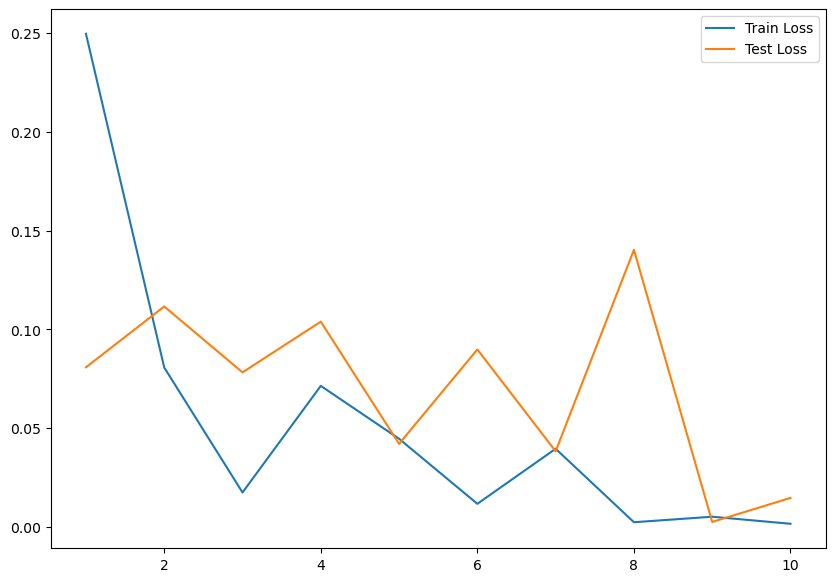

In [12]:
epochs = range(1, NUM_EPOCHS+1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_train_stat)
plt.plot(epochs, loss_test_stat)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

[0.9375, 0.9765625, 1.0, 0.9765625, 0.984375, 0.9921875, 0.9921875, 1.0, 1.0, 1.0]


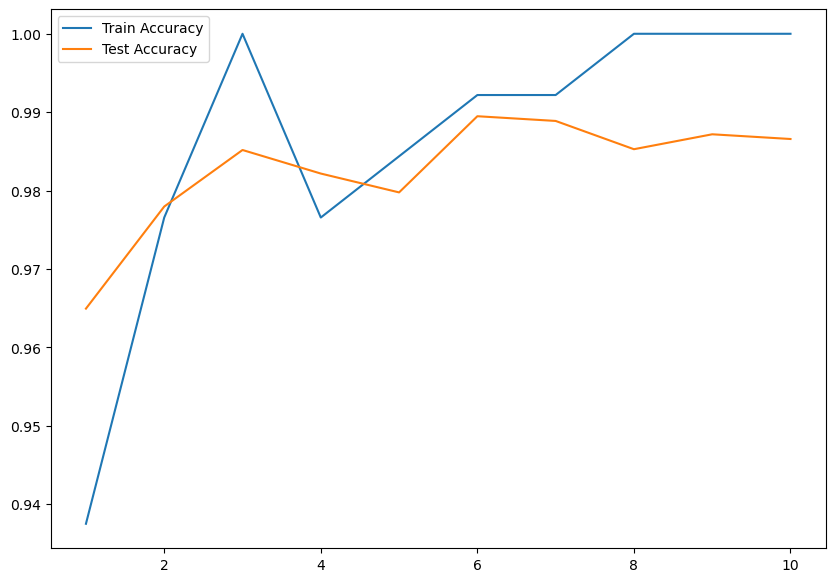

In [13]:
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(10, 7))
print(accuracy_train_stat)
plt.plot(epochs, accuracy_train_stat)
plt.plot(epochs, accuracy_test_stat)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [14]:
import cv2
import numpy as np

data = []
classes = [2, 3, 6, 8, 9, 1, 0, 4, 7, 5]
for i in range(10):
    img = cv2.imread("../my_dataset/"+str(i+1)+".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sharp_filter = np.array([[-1, 0, -1],
                             [ 0, 7,  0],
                             [-1, 0, -1]])
    img = cv2.filter2D(img, ddepth=-1, kernel=sharp_filter)

    img = cv2.bitwise_not(img)
    img = img.astype('float32')
    data.append(img)

data = np.reshape(data,(len(data), 1, 28, 28))
# data = np.array(data)
classes = np.array(classes)

print(data.shape)

(10, 1, 28, 28)


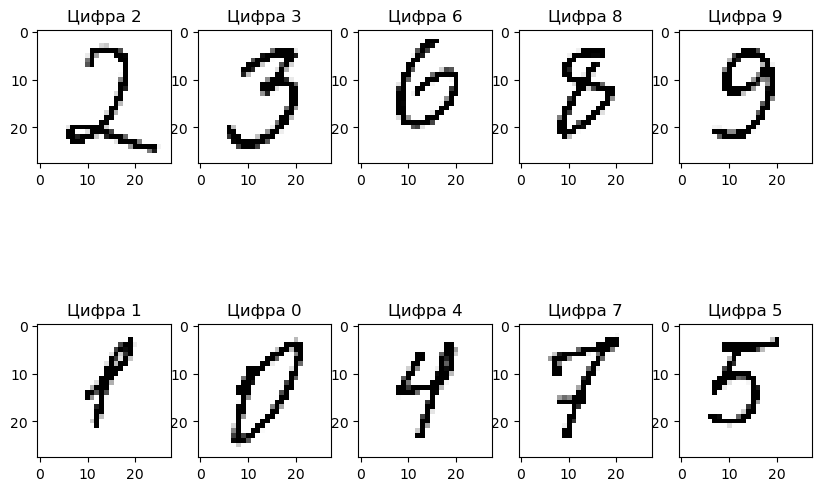

In [15]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % classes[i])

In [16]:
experiment_dataset = TensorDataset(torch.from_numpy(data).float(),
                                   torch.from_numpy(classes).long())
experiment_loader = DataLoader(experiment_dataset,
                          shuffle=False,
                          # pin_memory=True,
                          # num_workers=8,
                          # drop_last=True,

                          batch_size=BATCH_SIZE)

mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in experiment_loader:
        outputs = mnistnet(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")


Test accuracy: 100.0 %


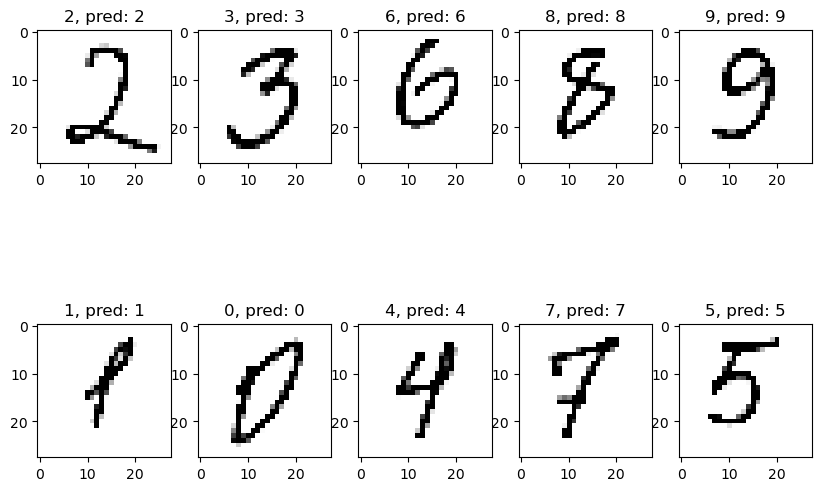

In [17]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (classes[i], predicted[i]))

In [18]:
import random
X_test_pixel = []
y_test_pixel = y_test
for i, img in enumerate(X_test):
    x = int(7 + random.random() * 14)
    y = int(7 + random.random() * 14)
    print(img[0][y][x])

    if img[0][y][x] <= 127:
        img[0][y][x] = 0
    else:
        img[0][y][x] = 255


    X_test_pixel.append(img)

170.0
176.0
0.0
0.0
0.0
0.0
244.0
35.0
0.0
146.0
0.0
6.0
79.0
253.0
0.0
0.0
0.0
0.0
0.0
0.0
254.0
106.0
0.0
8.0
37.0
0.0
252.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
63.0
0.0
0.0
0.0
0.0
70.0
0.0
0.0
0.0
0.0
0.0
253.0
254.0
185.0
0.0
228.0
0.0
0.0
0.0
195.0
247.0
184.0
85.0
128.0
253.0
0.0
0.0
0.0
0.0
0.0
0.0
255.0
0.0
0.0
0.0
12.0
0.0
42.0
253.0
0.0
0.0
0.0
253.0
232.0
0.0
187.0
0.0
84.0
253.0
92.0
253.0
135.0
171.0
167.0
253.0
149.0
0.0
0.0
253.0
0.0
253.0
253.0
250.0
254.0
0.0
92.0
253.0
0.0
254.0
0.0
0.0
0.0
0.0
175.0
0.0
0.0
0.0
113.0
0.0
0.0
0.0
150.0
185.0
252.0
22.0
114.0
0.0
253.0
0.0
0.0
0.0
255.0
0.0
252.0
0.0
255.0
0.0
0.0
0.0
0.0
255.0
253.0
210.0
14.0
253.0
166.0
0.0
61.0
0.0
253.0
0.0
78.0
0.0
254.0
201.0
103.0
0.0
0.0
85.0
254.0
0.0
35.0
0.0
0.0
0.0
253.0
254.0
5.0
0.0
140.0
0.0
0.0
0.0
0.0
252.0
0.0
121.0
0.0
13.0
0.0
51.0
0.0
0.0
0.0
0.0
253.0
0.0
251.0
254.0
0.0
0.0
253.0
0.0
0.0
0.0
0.0
253.0
0.0
0.0
0.0
0.0
0.0
252.0
120.0
254.0
0.0
0.0
0.0
0.0
252.0
254.0
0.0
252

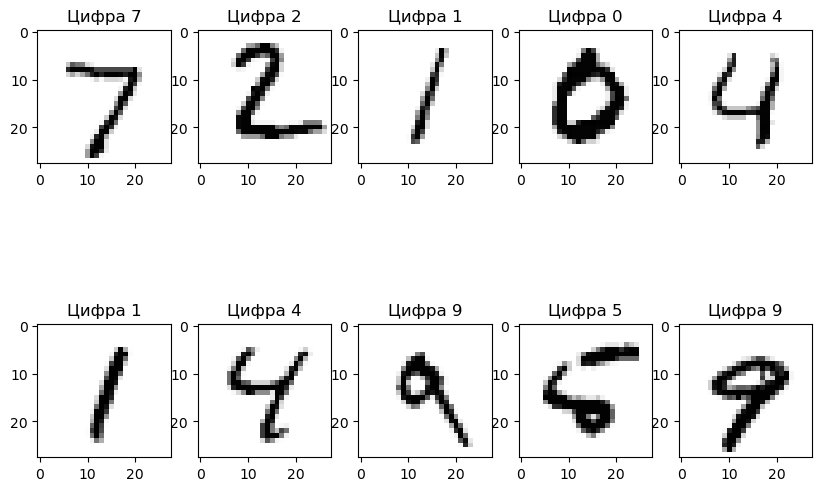

In [19]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test_pixel[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % y_test_pixel[i])

In [20]:
X_test_pixel = np.reshape(X_test_pixel,(len(X_test_pixel), 1, 28, 28))
# data = np.array(data)
y_test_pixel = np.array(y_test_pixel)

In [21]:
pixel_dataset = TensorDataset(torch.from_numpy(X_test_pixel).float(),
                             torch.from_numpy(y_test_pixel).long())
pixel_loader = DataLoader(pixel_dataset,
                          shuffle=False,
                          # pin_memory=True,
                          # num_workers=8,
                          # drop_last=True,
                          batch_size=BATCH_SIZE)

In [22]:
mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predict_results = []
    for images, labels in pixel_loader:
        outputs = mnistnet(images)
        predicted_pixel = torch.argmax(outputs, dim=1)
        predict_results+=predicted_pixel
        total += labels.shape[0]
        correct += (predicted_pixel == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")

Test accuracy: 98.65 %


10000


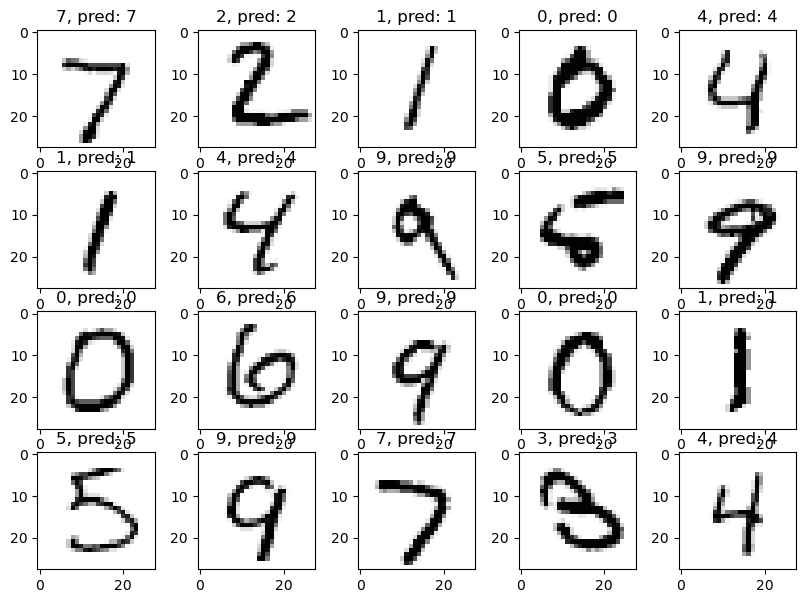

In [23]:
plt.figure(figsize=(10, 7))
print(len(predict_results))
for i in range(0, 20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test_pixel[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (y_test_pixel[i], predict_results[i]))

In [59]:
torch.save(mnistnet, 'mnistnet.pkl')

In [60]:
mdl = torch.load('mnistnet.pkl')
mdl

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [56]:
for images, labels in test_loader:
        outputs = mdl(images)
        predicted = torch.argmax(outputs, dim=1)

        print((predicted == labels).sum().item() / len(labels))

1.0
0.984375
0.984375
0.984375
0.9921875
0.9765625
0.984375
0.9765625
0.9296875
0.9921875
0.984375
0.9609375
0.96875
0.9921875
0.9921875
0.9921875
0.9921875
0.9921875
0.984375
0.984375
0.9765625
0.9921875
0.96875
0.9765625
0.984375
0.9921875
0.96875
1.0
0.9921875
0.9921875
0.9765625
0.96875
1.0
0.984375
0.9921875
1.0
0.9765625
1.0
0.984375
0.9921875
0.96875
0.9765625
0.9921875
1.0
0.984375
0.9921875
0.9921875
0.9921875
0.9765625
1.0
1.0
0.984375
1.0
0.9921875
0.9921875
0.9765625
0.9921875
0.9921875
0.9765625
0.9921875
0.9765625
0.9765625
0.9921875
0.9921875
0.984375
1.0
1.0
0.984375
1.0
0.9921875
0.9765625
0.9765625
0.9921875
1.0
0.984375
0.9921875
0.9921875
1.0
